In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({'font.size': 14})
from copy import deepcopy
from scipy.stats import sem
import pickle

from funcs_data_preprocessing import import_data, add_game_index
from funcs_data_analysis import *
from info_model import *
from funcs_model_analysis import *
from funcs_alternative_choices_analysis import *

# Load data and model predictions

Get trial-by-trial log likelihoodand probability for alternative choices

## cog model

In [2]:
data_cog = pd.read_csv('cog_model_pAllChoices.csv')
data_cog, _ = calculate_metrics(data_cog, dataType='real')
data_cog_test = get_test_games(data_cog)
data_cog_test = getPConfusion(data_cog_test, 'cog')

## RNNs

In [3]:
data, workerIds = import_data(getWorkerIds=True)
data, _ = calculate_metrics(data, dataType='real')
data = get_test_games(data)

data_RNN_test = dict()
for net in ['LSTM', 'LSTM_embed']:
    _, llh_test, p_allChoices = load_winning_model(datasetType='data', modelName=net, returnLlh=True)
    data_RNN_test[net] = deepcopy(data)
    data_RNN_test[net][net + '_loglikelihood'] = llh_test.reshape(-1,1).squeeze()
    for iChoice in range(NChoices):
        data_RNN_test[net]['p_allChoices' + str(iChoice)] = [p_allChoices[iTrial][iChoice] for iTrial in range(len(p_allChoices))]
    data_RNN_test[net] = getPConfusion(data_RNN_test[net], 'RNN')

{'hidden_size': 50, 'n_epochs': 1000, 'lr_init': 0.001, 'lr_adjust_type': 'Adam', 'batch_size': 10000} 28
GPU not available, CPU used
GPU not available, CPU used
{'hidden_size': 50, 'n_epochs': 200, 'lr_init': 0.001, 'lr_adjust_type': 'Adam', 'batch_size': 10000, 'embed_size': {'subjID': 3}} 23
GPU not available, CPU used
GPU not available, CPU used


# Model comparison

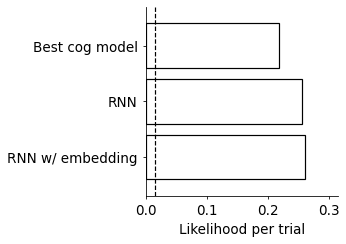

In [4]:
# compare the likelihood per trial of all models (bar plot)
plt.rcParams.update({'font.size': 13.5})
fig, ax = plt.subplots(1, figsize=(5, 3.6))
models = ['cog', 'LSTM', 'LSTM_embed']
for iM, model in enumerate(models):
    if model == 'cog':
        lik = np.exp(np.mean(data_cog_test[cog_model + '_loglikelihood']))
    else:
        lik =  np.exp(np.mean(data_RNN_test[model][model + '_loglikelihood']))
    ax.barh(iM, lik, color='w', edgecolor='k', linewidth=1.2)

ax.yaxis.set_ticks_position('left')
ax.yaxis.set_label_position('left')
ax.spines['left'].set_position(('data', 0))
ax.set_yticks(np.arange(len(models)))
ax.set_yticklabels(['Best cog model']+list(net_label.values()))
ax.set_ylim([-0.7, len(models) - 0.3])
ax.set_xlim([0, 0.315])
ax.set_xticks([0, 0.1, 0.2, 0.3])
ax.set_xlabel('Likelihood per trial', labelpad=5)
ax.tick_params(axis='both', length=3, pad=5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.vlines(x=1/63, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='k', linestyles='dashed', linewidth=1.2)
ax.invert_yaxis()
plt.tight_layout()
plt.show()

# RNN vs cog

In [5]:
for net in ['LSTM', 'LSTM_embed']:
    data_RNN_test[net]['diff_cog_loglik'] = data_RNN_test[net][net + '_loglikelihood'] - data_cog_test[cog_model + '_loglikelihood']
    data_RNN_test[net]['diff_cog_lik'] = np.exp(data_RNN_test[net][net + '_loglikelihood']) - np.exp(data_cog_test[cog_model + '_loglikelihood'])

In [6]:
net = 'LSTM'
colors = {'cog': 'C0', 'LSTM': 'C1'}

## loglik difference ~ trial index

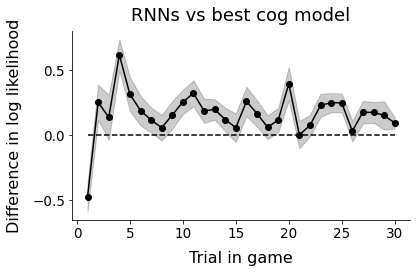

In [7]:
fig, ax = plt.subplots()

mean = data_RNN_test[net].groupby(['workerId','trial']).mean()['diff_cog_loglik'].groupby('trial').mean()
sem = data_RNN_test[net].groupby(['workerId','trial']).mean()['diff_cog_loglik'].groupby('trial').agg('sem')
ax.plot(data['trial'].unique(), mean, marker='o', color='k')
ax.fill_between(data['trial'].unique(), mean-sem, mean+sem, alpha=0.2, color='k')
    
ax.set_yticks([-0.5,0,0.5])
ax.set_ylabel('Difference in log likelihood', labelpad=10, fontsize=16)
ax.set_xlabel('Trial in game', labelpad=10, fontsize=16)
ax.set_title('RNNs vs best cog model', fontsize=18, pad=10)
ax.hlines(y=0, xmin=data['trial'].unique().min(), xmax=data['trial'].unique().max(), colors='k', linestyles='dashed')
sns.despine()
plt.tight_layout()

## Switch trials

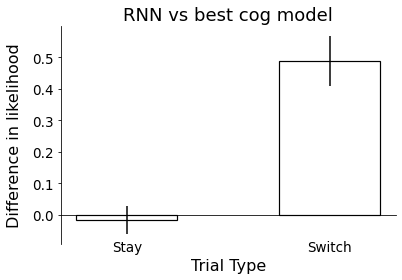

In [8]:
fig, ax = plt.subplots()
mean = data_RNN_test[net].groupby(['workerId', 'add_choiceChange'])['diff_cog_loglik'].mean().groupby('add_choiceChange').mean()
sem = data_RNN_test[net].groupby(['workerId', 'add_choiceChange'])['diff_cog_loglik'].mean().groupby('add_choiceChange').agg('sem')
ax.bar(x=[0,1], height=mean, yerr=sem, color='w', edgecolor='k', linewidth=1.2, width=0.5)
ax.set_xticks([0,1])
ax.set_xticklabels(labels=['Stay', 'Switch'])
ax.tick_params(axis='x', which='both', pad=25, length=0)
ax.set_xlabel('Trial Type', fontsize=16)
ax.set_ylabel('Difference in likelihood', labelpad=10, fontsize=16)
ax.set_title(net_label[net] + ' vs best cog model', fontsize=18)
sns.despine()
ax.spines['bottom'].set_position('zero')

## hit rate ~ stay vs switch

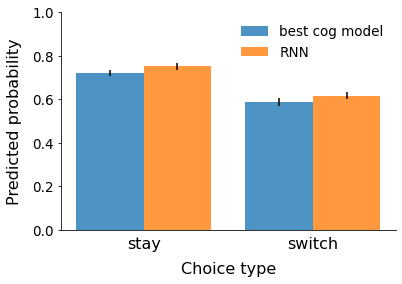

In [9]:
fig, ax = plt.subplots()
for i, model in enumerate(['cog', net]):
    data_tmp = data_cog_test if model == 'cog' else data_RNN_test[net]
    p = dict()
    hit_stay_mean = data_tmp[data_tmp['add_choiceChange']==0].groupby('workerId')['ptotal_complast_numdimdiff0'].mean().mean()
    hit_stay_sem = data_tmp[data_tmp['add_choiceChange']==0].groupby('workerId')['ptotal_complast_numdimdiff0'].mean().agg('sem')
    hit_switch_mean = 1 - data_tmp[(data_tmp['add_choiceChange']==1) & (data_tmp['trial']>1)].groupby('workerId')['ptotal_complast_numdimdiff0'].mean().mean()
    hit_switch_sem = data_tmp[(data_tmp['add_choiceChange']==1) & (data_tmp['trial']>1)].groupby('workerId')['ptotal_complast_numdimdiff0'].mean().agg('sem')
    plt.bar(x=[-0.2+i*0.4], height=hit_stay_mean, yerr=hit_stay_sem, width=0.4, alpha=0.8, color=colors[model], label='best cog model' if model=='cog' else net_label[net])
    plt.bar(x=[0.8+i*0.4], height=hit_switch_mean, yerr=hit_switch_sem, width=0.4, alpha=0.8, color=colors[model])
plt.xticks([0,1], labels=['stay', 'switch'], fontsize=16)
plt.xlabel('Choice type', fontsize=16, labelpad=10)
plt.ylabel('Predicted probability', labelpad=10, fontsize=16)
ax.tick_params(axis='x', which='both', length=0, pad=7)
sns.despine()
plt.legend(frameon=False)
plt.ylim([0,1])
plt.show()

## # features selected

### Comparison of abs error on expected # features selected

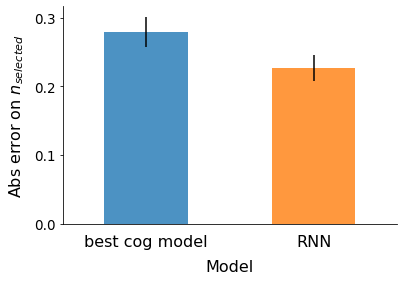

In [10]:
fig, ax = plt.subplots()
for i, model in enumerate(['cog', net]):
    tmp = data_cog_test if model == 'cog' else data_RNN_test[net]
    tmp['absErrorNumFeatureSelected'] = np.abs(np.sum([tmp['ptotal_numFeatureSelected'+str(num)] * num for num in range(numFeaturesPerDimension+1)], axis=0) - tmp['numSelectedFeatures'])
    absErr = tmp.groupby('workerId')['absErrorNumFeatureSelected'].mean()
    plt.bar(x=i, height=np.mean(absErr), yerr=np.std(absErr)/np.sqrt(len(absErr)), color=colors[model], alpha=0.8, width=0.5)
    plt.xticks(ticks=[0,1], labels=['best cog model', net_label[net]], fontsize=16)
    plt.yticks(ticks=[0,0.1,0.2,0.3])
    plt.xlabel('Model', labelpad=10, fontsize=16)
    plt.ylabel('Abs error on $n_{selected}$', labelpad=8, fontsize=16)
    plt.xlim([-0.5, 1.5])
    ax.tick_params(axis='x', which='both', length=0, pad=10)
sns.despine()

### log lik diff ~ abs error on expected # features selected diff

<Figure size 432x288 with 0 Axes>

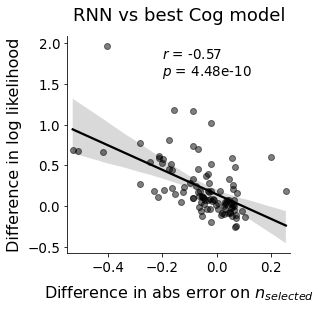

In [11]:
from scipy.stats import pearsonr
plt.figure()
absErr, loglik = dict(), dict()
for i, model in enumerate(['cog', net]):
    tmp = data_cog_test if model == 'cog' else data_RNN_test[net]
    tmp['loglik'] = np.log(tmp['lik'])
    tmp['absErrorNumFeatureSelected'] = np.abs(np.sum([tmp['ptotal_numFeatureSelected'+str(num)] * num for num in range(numFeaturesPerDimension+1)], axis=0) - tmp['numSelectedFeatures'])
    absErr[model] = tmp.groupby('workerId')['absErrorNumFeatureSelected'].mean()
    loglik[model] = tmp.groupby('workerId')['loglik'].mean()
fig, ax = plt.subplots(figsize=(4,4))
x = absErr[net]-absErr['cog']
y = loglik[net]-loglik['cog']
r, p = pearsonr(x=x, y=y)
sns.regplot(x=x, y=y, color='k', ax=ax, scatter_kws={'alpha':0.5})
ax.set_xlim([-0.55, 0.27])
plt.xlabel('Difference in abs error on $n_{selected}$', labelpad=10, fontsize=16)
plt.ylabel('Difference in log likelihood', labelpad=5, fontsize=16)
plt.title(net_label[net] + ' vs best Cog model', fontsize=18, pad=15)
plt.text(x=-0.2, y=1.6, s='$r$ = ' + str(np.round(r,2)) + '\n$p$ = ' + '{:0.2e}'.format(p))
sns.despine()

### alternative choices on switch trials

cog
correct / all w/ same # feature selected: 0.18752806129735586
correct / switch w/ same # feature selected: 0.24147580019996434
LSTM
correct / all w/ same # feature selected: 0.25026367511545156
correct / switch w/ same # feature selected: 0.3037467911525699


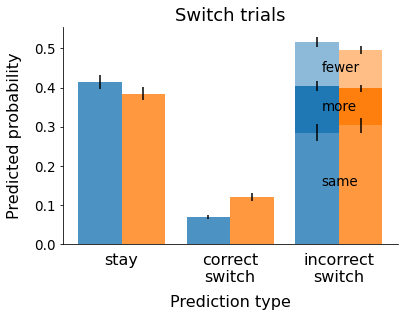

In [12]:
fig, ax = plt.subplots()
for i, model in enumerate(['cog', net]):
    tmp = data_cog_test[data_cog_test['add_choiceChange']==True] if model == 'cog' else data_RNN_test[net][data_RNN_test[net]['add_choiceChange']==True]
    p_stay = tmp.groupby('workerId')['ptotal_complast_numdimdiff0'].mean()
    p_switchCorrect = tmp.groupby('workerId')['lik'].mean()
    p_switchMore = tmp.groupby('workerId')['ptotal_switch_numFeaturesSelectedMore'].mean()
    p_switchLess = tmp.groupby('workerId')['ptotal_switch_numFeaturesSelectedLess'].mean()
    p_switchSame = 1 - p_stay - p_switchCorrect - p_switchMore - p_switchLess
    print(model)
    print('correct / all w/ same # feature selected: ' + str(np.nanmean(tmp['lik'] / tmp['ptotal_numFeaturesSelectedDiff0'])))
    print('correct / switch w/ same # feature selected: ' + str(np.nanmean(tmp['lik'] / (1 - tmp['ptotal_complast_numdimdiff0'] - tmp['ptotal_switch_numFeaturesSelectedMore'] - tmp['ptotal_switch_numFeaturesSelectedLess']))))
    p = [p_stay, p_switchCorrect]
    plt.bar(x=i/2.5-0.2, height=p_stay.mean(), yerr=p_stay.agg('sem'), width=0.4, color=colors[model], alpha=0.8, label='best cog model' if model=='cog' else net_label[net])
    plt.bar(x=1+i/2.5-0.2, height=p_switchCorrect.mean(), yerr=p_switchCorrect.agg('sem'), width=0.4, color=colors[model], alpha=0.8)
    plt.bar(x=2+i/2.5-0.2, height=p_switchSame.mean(), yerr=p_switchSame.agg('sem'), width=0.4, color=colors[model], alpha=0.8)
    plt.bar(x=2+i/2.5-0.2, bottom=p_switchSame.mean(), height=p_switchMore.mean(), yerr=p_switchMore.agg('sem'), width=0.4, color=colors[model], alpha=1)
    plt.bar(x=2+i/2.5-0.2, bottom=(p_switchSame+p_switchMore).mean(), height=p_switchLess.mean(), yerr=p_switchLess.agg('sem'), width=0.4, color=colors[model], alpha=0.5)
plt.text(x=1.84, y=0.15, s='same')
plt.text(x=1.84, y=0.34, s='more')
plt.text(x=1.84, y=0.44, s='fewer')
plt.xticks(ticks=range(len(p)+1), labels=['stay', 'correct\nswitch', 'incorrect\nswitch'], fontsize=16)
plt.ylabel('Predicted probability', labelpad=12, fontsize=16)
plt.xlabel('Prediction type', labelpad=10, fontsize=16)
plt.title('Switch trials', fontsize=18)
ax.tick_params(axis='x', which='both', length=0, pad=8)
sns.despine()

# RNN w/ embedding vs RNN

## loglik difference ~ trial index

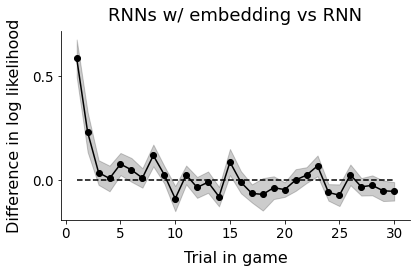

In [13]:
fig, ax = plt.subplots()

data_RNN_test['LSTM_embed']['diff_LSTM_loglik'] = data_RNN_test['LSTM_embed']['LSTM_embed_loglikelihood'] - data_RNN_test['LSTM']['LSTM_loglikelihood']
mean = data_RNN_test['LSTM_embed'].groupby(['workerId','trial']).mean()['diff_LSTM_loglik'].groupby('trial').mean()
sem = data_RNN_test['LSTM_embed'].groupby(['workerId','trial']).mean()['diff_LSTM_loglik'].groupby('trial').agg('sem')
ax.plot(data['trial'].unique(), mean, marker='o', color='k')
ax.fill_between(data['trial'].unique(), mean-sem, mean+sem, alpha=0.2, color='k')
    
ax.set_yticks([-0.5,0,0.5])
ax.set_ylabel('Difference in log likelihood', labelpad=10, fontsize=16)
ax.set_xlabel('Trial in game', labelpad=10, fontsize=16)
ax.set_title('RNNs w/ embedding vs RNN', fontsize=18, pad=10)
ax.hlines(y=0, xmin=data['trial'].unique().min(), xmax=data['trial'].unique().max(), colors='k', linestyles='dashed')
sns.despine()
plt.tight_layout()